# Focus on Ackley function of different $d$ *only*
Now using absolute $\beta = 0.01$ step instead of  $\beta/\beta_{max}= 0.01$

In [15]:
import sys
sys.path.insert(1, '/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import getdist
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import numpy as np
import scipy
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
from jax.scipy.stats import uniform
import chaospy
from nfmc_jax.sinf.RQspline import kde
import torch
from scipy.special import loggamma
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)
warnings.filterwarnings('ignore') #ignore overflow warnings



### Misc functions

In [24]:
def t2a(tens): return tens.numpy().astype(np.float64)
def a2t(arr): return torch.from_numpy(arr.astype(np.float32))
def log_flat_one(x,low,high): #set prior to 1 for these pure optimization examples
    n=x.shape[-1]
    return 0

def get_metrics(trace,verbose=True):
    #add maxp point
    maxq=np.max(np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())]))
    maxidx=np.argmax(trace['logp'][0]['q{0}'.format(maxq)])
    s_maxp = trace['q_samples'][0]['q{0}'.format(maxq)][maxidx]
    maxp = trace['logp'][0]['q{0}'.format(maxq)][maxidx]
    print('value of max logp = {0}, at {1}, with {2} levels and {3} total calls'.format(maxp,s_maxp,maxq,len(trace['q_samples'][0]['q{0}'.format(maxq)])))
    return maxp,s_maxp,maxq,len(trace['q_samples'][0]['q{0}'.format(maxq)])

def plot_opt_gd(trace,opt_func,low,high,Ngd=1000,beta_idx=None,random_init=True):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]

    #for truth, evaluate on sobol points and apply weights
    if(random_init):
        init = np.random.uniform(low=low,high=high,size=(Ngd,n))
    else:
        init = np.atleast_2d(chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n).sample(Ngd,rule='sobol')).T
    
    truth = np.array([np.exp(opt_func(n,init[i])) for i in range(Ngd)]) #obviously this will be slow
    truth_gd = MCSamples(samples=init, weights=truth, names = names, labels = labels, label='truth')

    if(beta_idx is None): beta_idx=qnums.max()
    s_w,s_uw = t2a(qmodels[0]['q{0}_w'.format(beta_idx)].sample(Ngd,device='cpu')[0]),t2a(qmodels[0]['q{0}_uw'.format(beta_idx)].sample(Ngd,device='cpu')[0])
    samples_w = MCSamples(samples=s_w,names = names, labels = labels, label='q_w')
    samples_uw = MCSamples(samples=s_uw,names = names, labels = labels, label='q_uw')

    # Triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_uw,truth_gd,samples_w], filled=True,markers=dict(zip(names,get_metrics(trace)[1]))) #add maxp point
    

    plt.show()

In [17]:
#a place to put the common settings to declutter the below but still be transparent
def run_nfo(log_like,log_prior,
    n, #dim
    low=-1.,
    high=1.,
    knots=None,
    knots_trainable=5,
    bw=1.,
    rel_bw=1,
    layers=5,
    ktrunc=jnp.inf,
    t_ess=0.7,
    beta_max=1.5,
    rel_beta=0.5,
    frac_rel_beta_AF = 1,
    alpha_w = (0,0),
    alpha_uw = (0,0),
    latent_sigma=2.4/(2**2),  #FIXME put this in the code as default
    use_latent_beta2=False,
    use_pq_beta_IW1=False, 
    top_verbose=True,
    verbose=False,
    trainable_qw=True,
    sgd_steps=10,
    gamma=0,
    lossfunc=0,
    optimize_directions=False,
    a=1,
    b=1,
    c=1,
    d=1,
    N_temp=None,
    random_init=False,seed=seed,
    n_prior=None,
    retrain_SNF=False):
    if(N_temp is None): N_temp = 12*n
    if(n_prior is None): n_prior = 10*n
    n0=n_prior
    N=n_prior
    aN=int(2*N*a)
    bN=n*b
    cN=n*c
    dN=n*d
    if(n<6):
        latent_sigma=1
    else:
        latent_sigma*=((n)**(-1/2))
    dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
    bounds=np.array([low*np.ones(n),high*np.ones(n)])
    if(random_init):
        np.random.seed(seed)
        init_prior = np.random.uniform(low=low,high=high,size=(n_prior,n))
    else:
        init_prior=dist1d
        init_prior = np.atleast_2d(dist1d.sample(n_prior+1,rule='sobol')).T[1:] #drop first (0,0) sample because cheating
    trace = nfmc_jax.infer_nfomc(log_like, log_prior, jnp.array(init_prior), 
                             log_prior_args=((jnp.array([low]), jnp.array([high]))), 
                             inference_mode="optimization", 
                              vmap=True, parallel_backend=None, 
                               n0=n0,
                               N=N,
                               t_ess=t_ess,
                               N_AF=aN,
                               expl_top_AF=bN,
                               expl_top_qw=cN,
                               expl_latent=dN,
                               bounds=bounds,
                               beta_max=beta_max,
                               nf_iter=1, 
                               N_temp=N_temp,
                               rel_bw=rel_bw,
                               rel_beta=rel_beta,
                               frac_rel_beta_AF = frac_rel_beta_AF,
                               latent_sigma=latent_sigma,
                               use_latent_beta2=use_latent_beta2,
                               use_pq_beta_IW1=use_pq_beta_IW1,
                               k_trunc=ktrunc,
                               #sinf parameters
                               frac_validate=0.0,
                               alpha_w=alpha_w,
                               alpha_uw=alpha_uw,
                               NBfirstlayer=True, 
                               verbose=verbose,
                               top_verbose=top_verbose,interp_nbin=knots,iteration=layers,
                               bw_factor_min=bw,bw_factor_max=bw,bw_factor_num=1, #manually force bw factor
                               trainable_qw=trainable_qw,
                               sgd_steps=sgd_steps,
                               gamma=gamma,
                               knots_trainable=knots_trainable,
                               random_seed=seed,
                               train_updates=retrain_SNF,
                               lossfunc=lossfunc,
                               optimize_directions=optimize_directions
                             )
    
    return trace

In [18]:
# ackley definition
def log_ack(n,x):
    #global min is at zero, which is one of the sobol points, so slightly shift
    a,b,c = 20,0.2,2*jnp.pi
    term1 = -a * jnp.exp(-b*jnp.sqrt(jnp.mean(x**2)))
    term2 = -jnp.exp(jnp.mean(jnp.cos(c*x)))

    f = term1 + term2 + a + jnp.exp(1)
    return jnp.log(a + jnp.exp(1)-f) #check to make sure always pos

lb,ub = -5,10

### Values from the TuRBO paper

In [19]:
true_max = np.log(20 + np.exp(1))
print('truth (all d) ',true_max) #real max

# TuRBO gets value of 5 at 10k calls 
# For us a value of 5 means 
turbo200d = np.log(20 + np.exp(1) - 5)
print('TuRBO d=200 ',turbo200d)
#so we want to beat 2.9 if possible 

#for d=10 they get ~0.3
turbo10d = np.log(20 + np.exp(1) - 0.3)
print('TuRBO d=10 ', turbo10d)
print(-(np.exp(3.0)-20 - np.exp(1)))

truth (all d)  3.1231699672459294
TuRBO d=200  2.874596978199212
TuRBO d=10  3.1098767790453996
2.632744905271377


In [20]:
# plotting functions
def plot_maxs(traces=[],labels=[]):
    plt.figure()
    marker_cycler=['s','d','o','.']
    for j,trace in enumerate(traces):
        maxq=np.max(np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())]))
        for i in range(1,maxq+1):
            label = labels[j] if len(labels)>0 and i==1 else None
            plt.scatter(trace['betas'][0][i]*trace['q_samples'][0]['q_beta_true'],np.max(trace['logp'][0]['q{0}'.format(i)]),
                        c='C{0}'.format(j),label=label,marker=marker_cycler[j])
    plt.axhline(true_max,label='true maximum',ls='--',c='k')
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\max \{\log p\}$')
    plt.legend(prop={"size":10})
    plt.show()

### $d = 2$

In [21]:
def log_ack2(x): return log_ack(2,x)
n=2

Notes:
- $\beta_{\rm{max}}$ is high but not too high (5-7)
- $c\neq 0$ hurts
- need $b\geq2$
- rel_beta=1 rather than 0.5 helps **a lot**
- random init doesn't do much
- using retrain_SNF seems to make things worse, we stabilize at 3 instead of reaching the max...
- using more sgd steps (w/o retrain) doesn't seem to make a big change (and ofc gets slower)
- ESS of 0.9 gives better than 0.7 but .95/99/.85/.8/.75/ does much worse, but 0.71,0.74 is good again... 0.1,0.4,0.5 much worse - need to look at this in more detail

Vary $\beta_{\rm{max}}$

Inference mode is optimization. Maximum beta is: 5.0
Inference mode is optimization. Maximum beta is: 7.0
Inference mode is optimization. Maximum beta is: 10.0
beta_max = 5.0
value of max logp = 3.073436737060547, at [-0.14273548  0.08922386], with 7 levels and 48 total calls
beta_max = 7.0
value of max logp = 3.0137553215026855, at [-0.2597146  -0.17233992], with 9 levels and 56 total calls
beta_max = 10.0
value of max logp = 3.1081337928771973, at [0.06862068 0.02314806], with 11 levels and 64 total calls


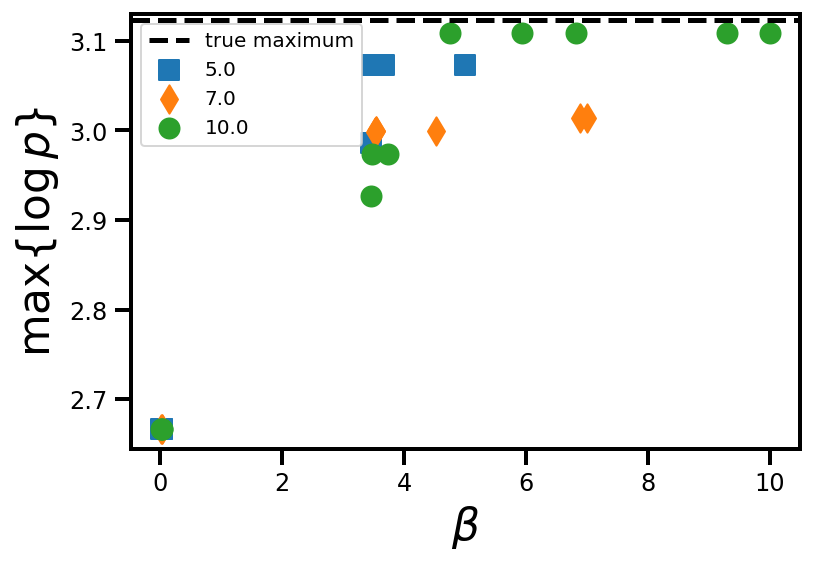

In [22]:
# Vary beta_max
bms,bmy = [5.,7.,10.],[]
for bm in bms: bmy.append(
                   run_nfo(n=2,log_like=log_ack2,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=bm,d=1,c=0,b=2,rel_beta=1,t_ess=0.9,lossfunc=2,
                 ))
for i,bmyi in enumerate(bmy):  #info about the run
    print("beta_max = {0}".format(float(bms[i])))
    get_metrics(bmyi)
plot_maxs(bmy,labels=bms) #plots

Removed no burn in
Removed no burn in
Removed no burn in
value of max logp = 3.1081337928771973, at [0.06862068 0.02314806], with 11 levels and 64 total calls


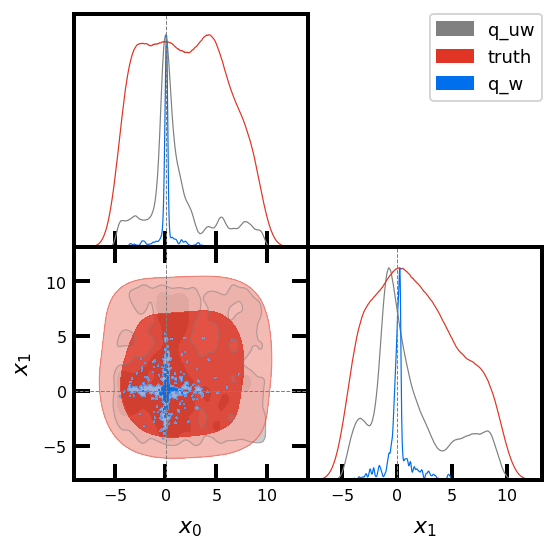

In [25]:
plot_opt_gd(bmy[-1],log_ack,lb,ub,beta_idx=None,Ngd=1000)


Making $\beta_{\rm{max}}$ too low seems to end us too early - same for too small ess threshold but this is not monotonic, seems very sensitive to ess threshold..

Try L2 loss

Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
lossfunc = 1.0
value of max logp = 2.990675926208496, at [-0.09241295 -0.91685677], with 10 levels and 60 total calls
lossfunc = 2.0
value of max logp = 3.1081337928771973, at [0.06862068 0.02314806], with 11 levels and 64 total calls


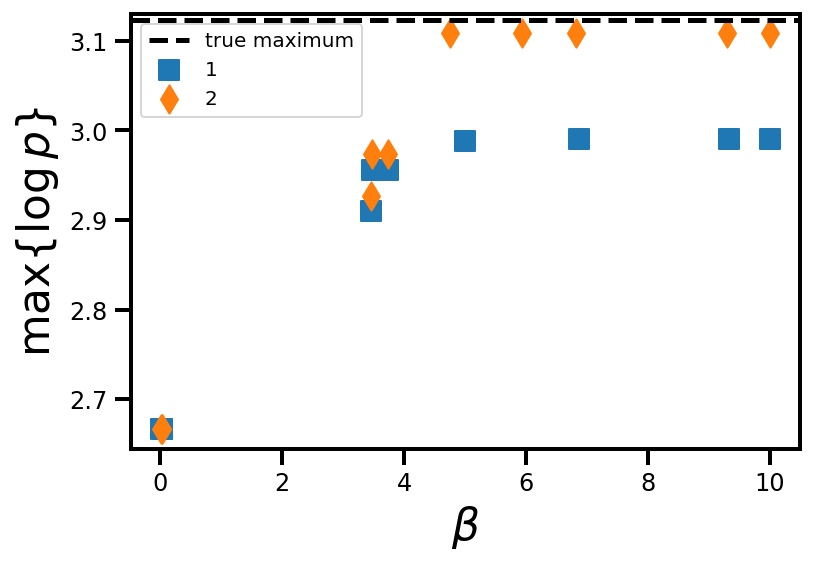

In [26]:
# L2 vs regular loss
lfs,lfy = [1,2],[]
for lf in lfs: lfy.append(
                   run_nfo(n=2,log_like=log_ack2,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=10,d=1,c=0,b=2,rel_beta=1,t_ess=0.9,lossfunc=lf,
                 ))
for i,lfyi in enumerate(lfy): 
    print("lossfunc = {0}".format(float(lfs[i])))
    get_metrics(lfyi)
plot_maxs(lfy,labels=lfs) 

retrain

Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
use_SNF = 1.0
value of max logp = 3.0089449882507324, at [0.34728003 0.0284214 ], with 19 levels and 96 total calls
use_SNF = 0.0
value of max logp = 3.1081337928771973, at [0.06862068 0.02314806], with 11 levels and 64 total calls


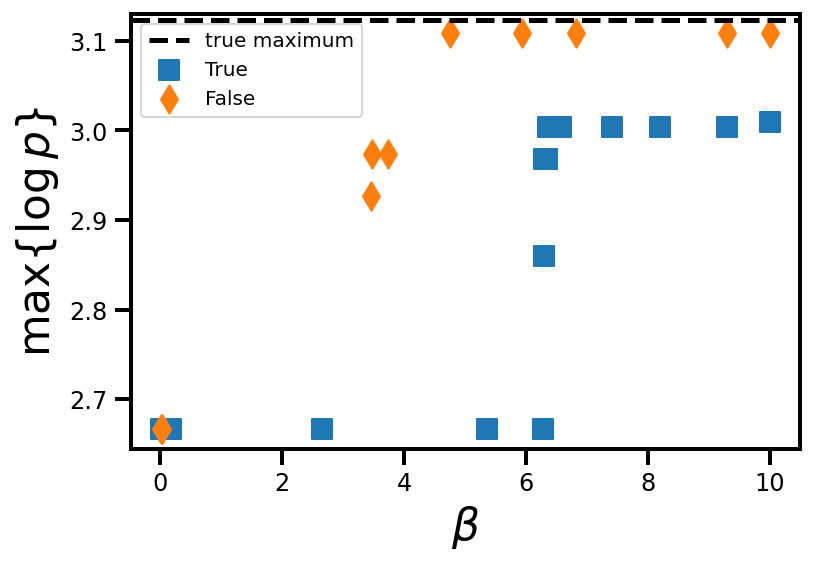

In [27]:
# SNF always vs usual
rets,rety = [True,False],[]
for ret in rets: rety.append(
                   run_nfo(n=2,log_like=log_ack2,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=10,d=1,c=0,b=2,rel_beta=1,t_ess=0.9,lossfunc=2,
                   retrain_SNF=ret
                 ))
for i,reti in enumerate(rety): 
    print("use_SNF = {0}".format(float(rets[i])))
    get_metrics(reti)
plot_maxs(rety,labels=rets) 

ess

In [28]:
def ess_schedule(N):
    t = 3.*(N)**(-1/2) #guessing at something in between for d=2
    return t

def fixed_schedule(N): #equivalent to what we used to do
    t=0.7
    return t
def impulse_schedule(N,t1=0.7,t2=0.9,switch=40,N0=20):
    if(N<=switch):
        t = t1*N0/N
    else:
        t = t2*switch/N #this will be equivalent to what was done before in each case
    return t

#other choices, maybe try beta_intern<0.5 use low value ow use fraction?
#maybe it is as simple as if beta<0.01 raise the ESS?


Text(0, 0.5, 'ESS threshold')

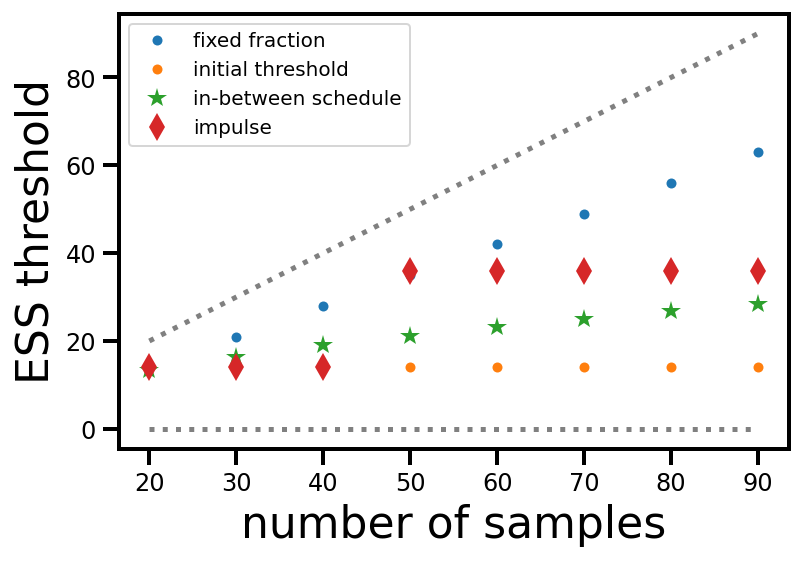

In [30]:
NN=np.arange(2,10)*10
plt.plot(NN,NN*0.7,ls=' ',marker='.',label='fixed fraction')
plt.plot(NN,NN,ls=':',c='gray')
plt.plot(NN,np.zeros(len(NN)),ls=':',c='gray')
plt.plot(NN,np.ones(len(NN))*NN[0]*0.7,ls=' ',marker='.',zorder=-1,label='initial threshold')
plt.plot(NN,ess_schedule(NN)*NN,ls=' ',marker='*',label='in-between schedule')
plt.plot(NN,np.array([impulse_schedule(N)*N for N in NN]),ls=' ',marker='d',label='impulse')

plt.legend(prop={'size':10})
plt.xlabel("number of samples")
plt.ylabel("ESS threshold")

Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
fixed fraction
value of max logp = 3.121173620223999, at [-0.01032305  0.00966167], with 50 levels and 220 total calls
initial threshold
value of max logp = 3.1124274730682373, at [0.03889132 0.04091263], with 8 levels and 52 total calls
in-between schedule
value of max logp = 3.109071969985962, at [0.06309938 0.02808571], with 12 levels and 68 total calls
impulse
value of max logp = 3.0947065353393555, at [0.05885267 0.09738827], with 21 levels and 104 total calls


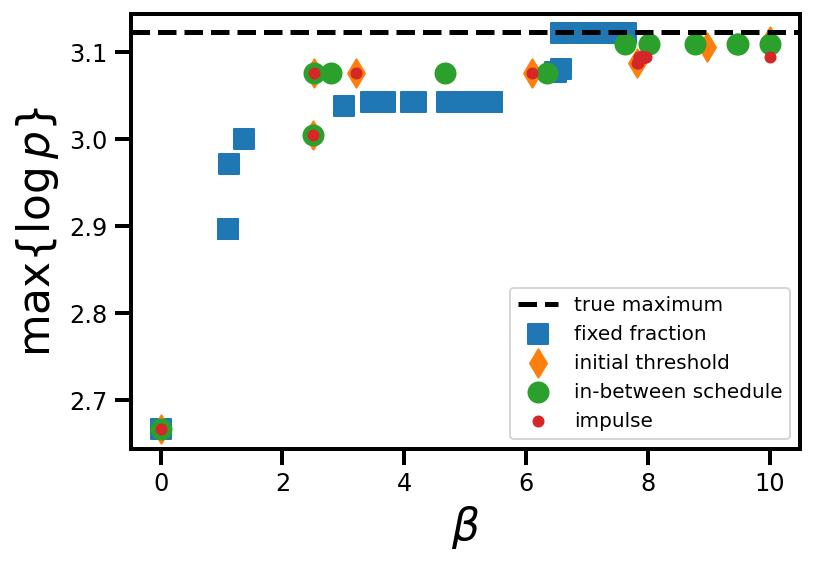

In [31]:
# Vary ess threshold - use 0.7 as initial for comparison though elsewhere have been using 0.9 (fixed 0.9 too many beta...)
ts,ty = [fixed_schedule,0.7,ess_schedule,impulse_schedule],[]
tlabels = ['fixed fraction','initial threshold','in-between schedule','impulse']
for t in ts: ty.append(
                   run_nfo(n=2,log_like=log_ack2,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=10,d=1,c=0,b=2,rel_beta=1,t_ess=t,lossfunc=2,
                   N_temp=50 #need to increase this to allow fixed fraction to finish under delta beta force...
                 ))
for i,tyi in enumerate(ty):  #info about the run
    print(tlabels[i])
    get_metrics(tyi)
plot_maxs(ty,labels=tlabels) #plots

## $d = 5$

In [32]:
def log_ack5(x): return log_ack(5,x)
n=5

$\beta_{\rm{max}}$

Inference mode is optimization. Maximum beta is: 7.0
Inference mode is optimization. Maximum beta is: 10.0
Inference mode is optimization. Maximum beta is: 15.0
beta_max = 7.0
value of max logp = 2.770890951156616, at [-0.17990494  3.0878305  -1.9774344   0.98594    -1.9540684 ], with 8 levels and 130 total calls
beta_max = 10.0
value of max logp = 2.8195762634277344, at [1.4899039  1.2724519  0.96755743 1.304452   0.9947243 ], with 12 levels and 170 total calls
beta_max = 15.0
value of max logp = 3.032522201538086, at [ 0.45304537 -0.15045547  0.08329439  0.05085039 -0.05892944], with 15 levels and 200 total calls


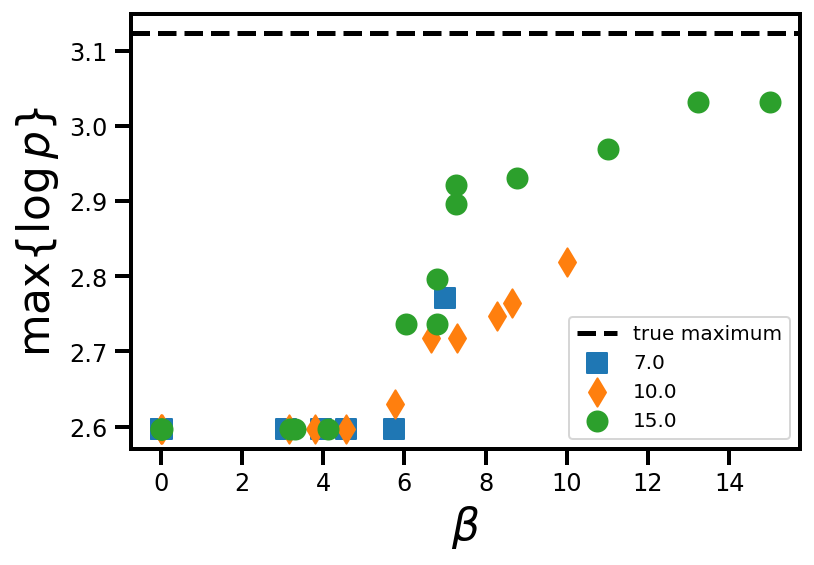

In [33]:
# Vary beta_max
bms5,bmy5 = [7.,10.,15.],[]
for bm in bms5: bmy5.append(
                   run_nfo(n=5,log_like=log_ack5,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=bm,d=1,c=0,b=2,rel_beta=1,t_ess=0.9,lossfunc=2,
                 ))
for i,bmyi in enumerate(bmy5):  #info about the run
    print("beta_max = {0}".format(float(bms5[i])))
    get_metrics(bmyi)
plot_maxs(bmy5,labels=bms5) #plots

In [34]:
def impulse_schedule5(N,t1=0.7,t2=0.9,switch=100,N0=50):
    if(N<=switch):
        t = t1*N0/N
    else:
        t = t2*switch/N #this will be equivalent to what was done before in each case
    return t

ess

Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
0.7
value of max logp = 2.932847261428833, at [-0.34423065  0.06706953  0.48770046  0.7584629   0.96295214], with 9 levels and 140 total calls
0.9
value of max logp = 2.8195762634277344, at [1.4899039  1.2724519  0.96755743 1.304452   0.9947243 ], with 12 levels and 170 total calls
impulse
value of max logp = 2.962836503982544, at [-0.03674459 -0.8457165   0.31540298 -0.21359205  0.8600564 ], with 17 levels and 220 total calls


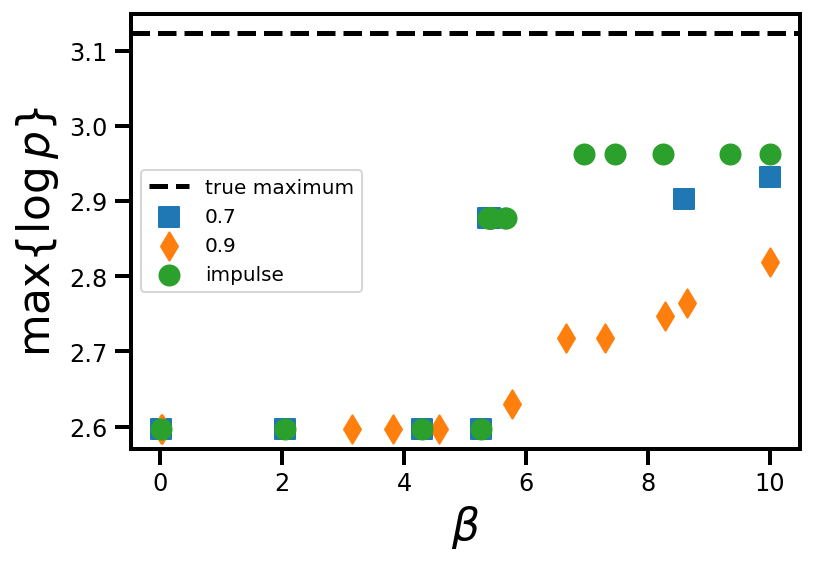

In [35]:
# Vary ess threshold 
ts5,ty5 = [0.7,0.9,impulse_schedule5],[]
tlabels5 = ['0.7','0.9','impulse']
for t in ts5: ty5.append(
                   run_nfo(n=5,log_like=log_ack5,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=10,d=1,c=0,b=2,rel_beta=1,t_ess=t,lossfunc=2,
                 ))
for i,tyi in enumerate(ty5):  #info about the run
    print(tlabels5[i])
    get_metrics(tyi)
plot_maxs(ty5,labels=tlabels5) #plots

Removed no burn in
Removed no burn in
Removed no burn in
value of max logp = 2.8195762634277344, at [1.4899039  1.2724519  0.96755743 1.304452   0.9947243 ], with 12 levels and 170 total calls


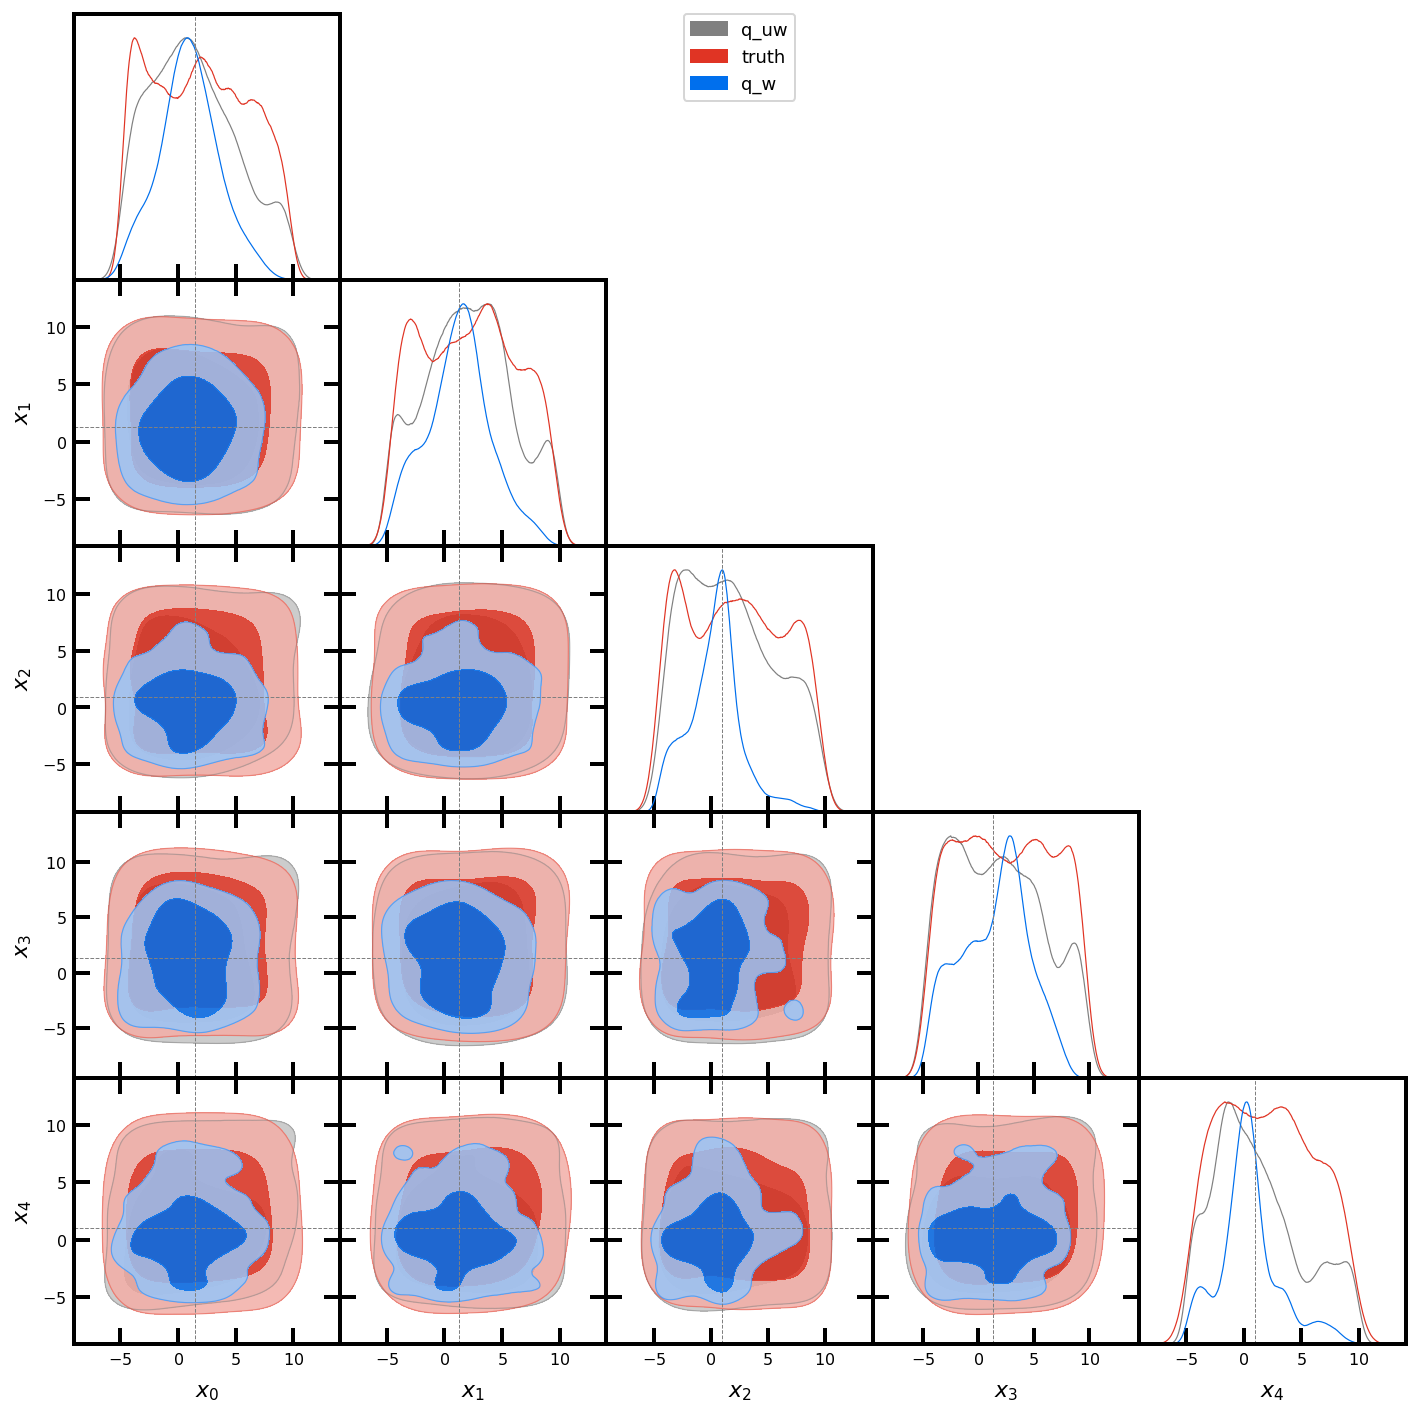

In [36]:
plot_opt_gd(bmy5[1],log_ack,lb,ub,beta_idx=None,Ngd=1000)

### $d = 10$

In [37]:
def log_ack10(x): return log_ack(10,x)
n=10

$\beta_{\rm{max}}$

Inference mode is optimization. Maximum beta is: 15.0
Inference mode is optimization. Maximum beta is: 20.0
Inference mode is optimization. Maximum beta is: 40.0
beta_max = 15.0
value of max logp = 2.864760398864746, at [ 1.5465531   0.24866009  0.02073479  0.7524848   2.0386782  -0.19095135
 -0.53582335  0.614089    0.24100351  1.1335912 ], with 21 levels and 520 total calls
beta_max = 20.0
value of max logp = 2.8971166610717773, at [ 0.70244265  1.410779   -0.20669222  1.6046057   0.77374744  0.8550525
 -0.36676311  0.01885653 -0.10156155 -0.07674456], with 22 levels and 540 total calls
beta_max = 40.0
value of max logp = 2.948512315750122, at [-0.09089851  0.69328976 -0.01459312 -0.2142992   0.24162865  0.47675896
  0.6708946   0.9412079   0.3164053   0.7901406 ], with 36 levels and 820 total calls


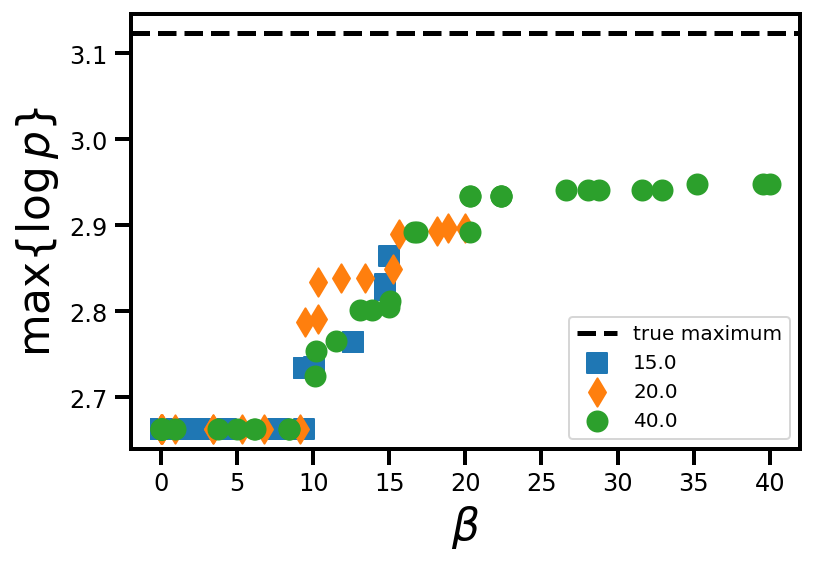

In [38]:
# Vary beta_max
bms10,bmy10 = [15.,20.,40.],[]
for bm in bms10: bmy10.append(
                   run_nfo(n=10,log_like=log_ack10,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=bm,d=1,c=0,b=2,rel_beta=1,t_ess=0.9,lossfunc=2,
                   
                 ))
for i,bmyi in enumerate(bmy10):  #info about the run
    print("beta_max = {0}".format(float(bms10[i])))
    get_metrics(bmyi)
plot_maxs(bmy10,labels=bms10) #plots

Removed no burn in
Removed no burn in
Removed no burn in
value of max logp = 2.948512315750122, at [-0.09089851  0.69328976 -0.01459312 -0.2142992   0.24162865  0.47675896
  0.6708946   0.9412079   0.3164053   0.7901406 ], with 36 levels and 820 total calls


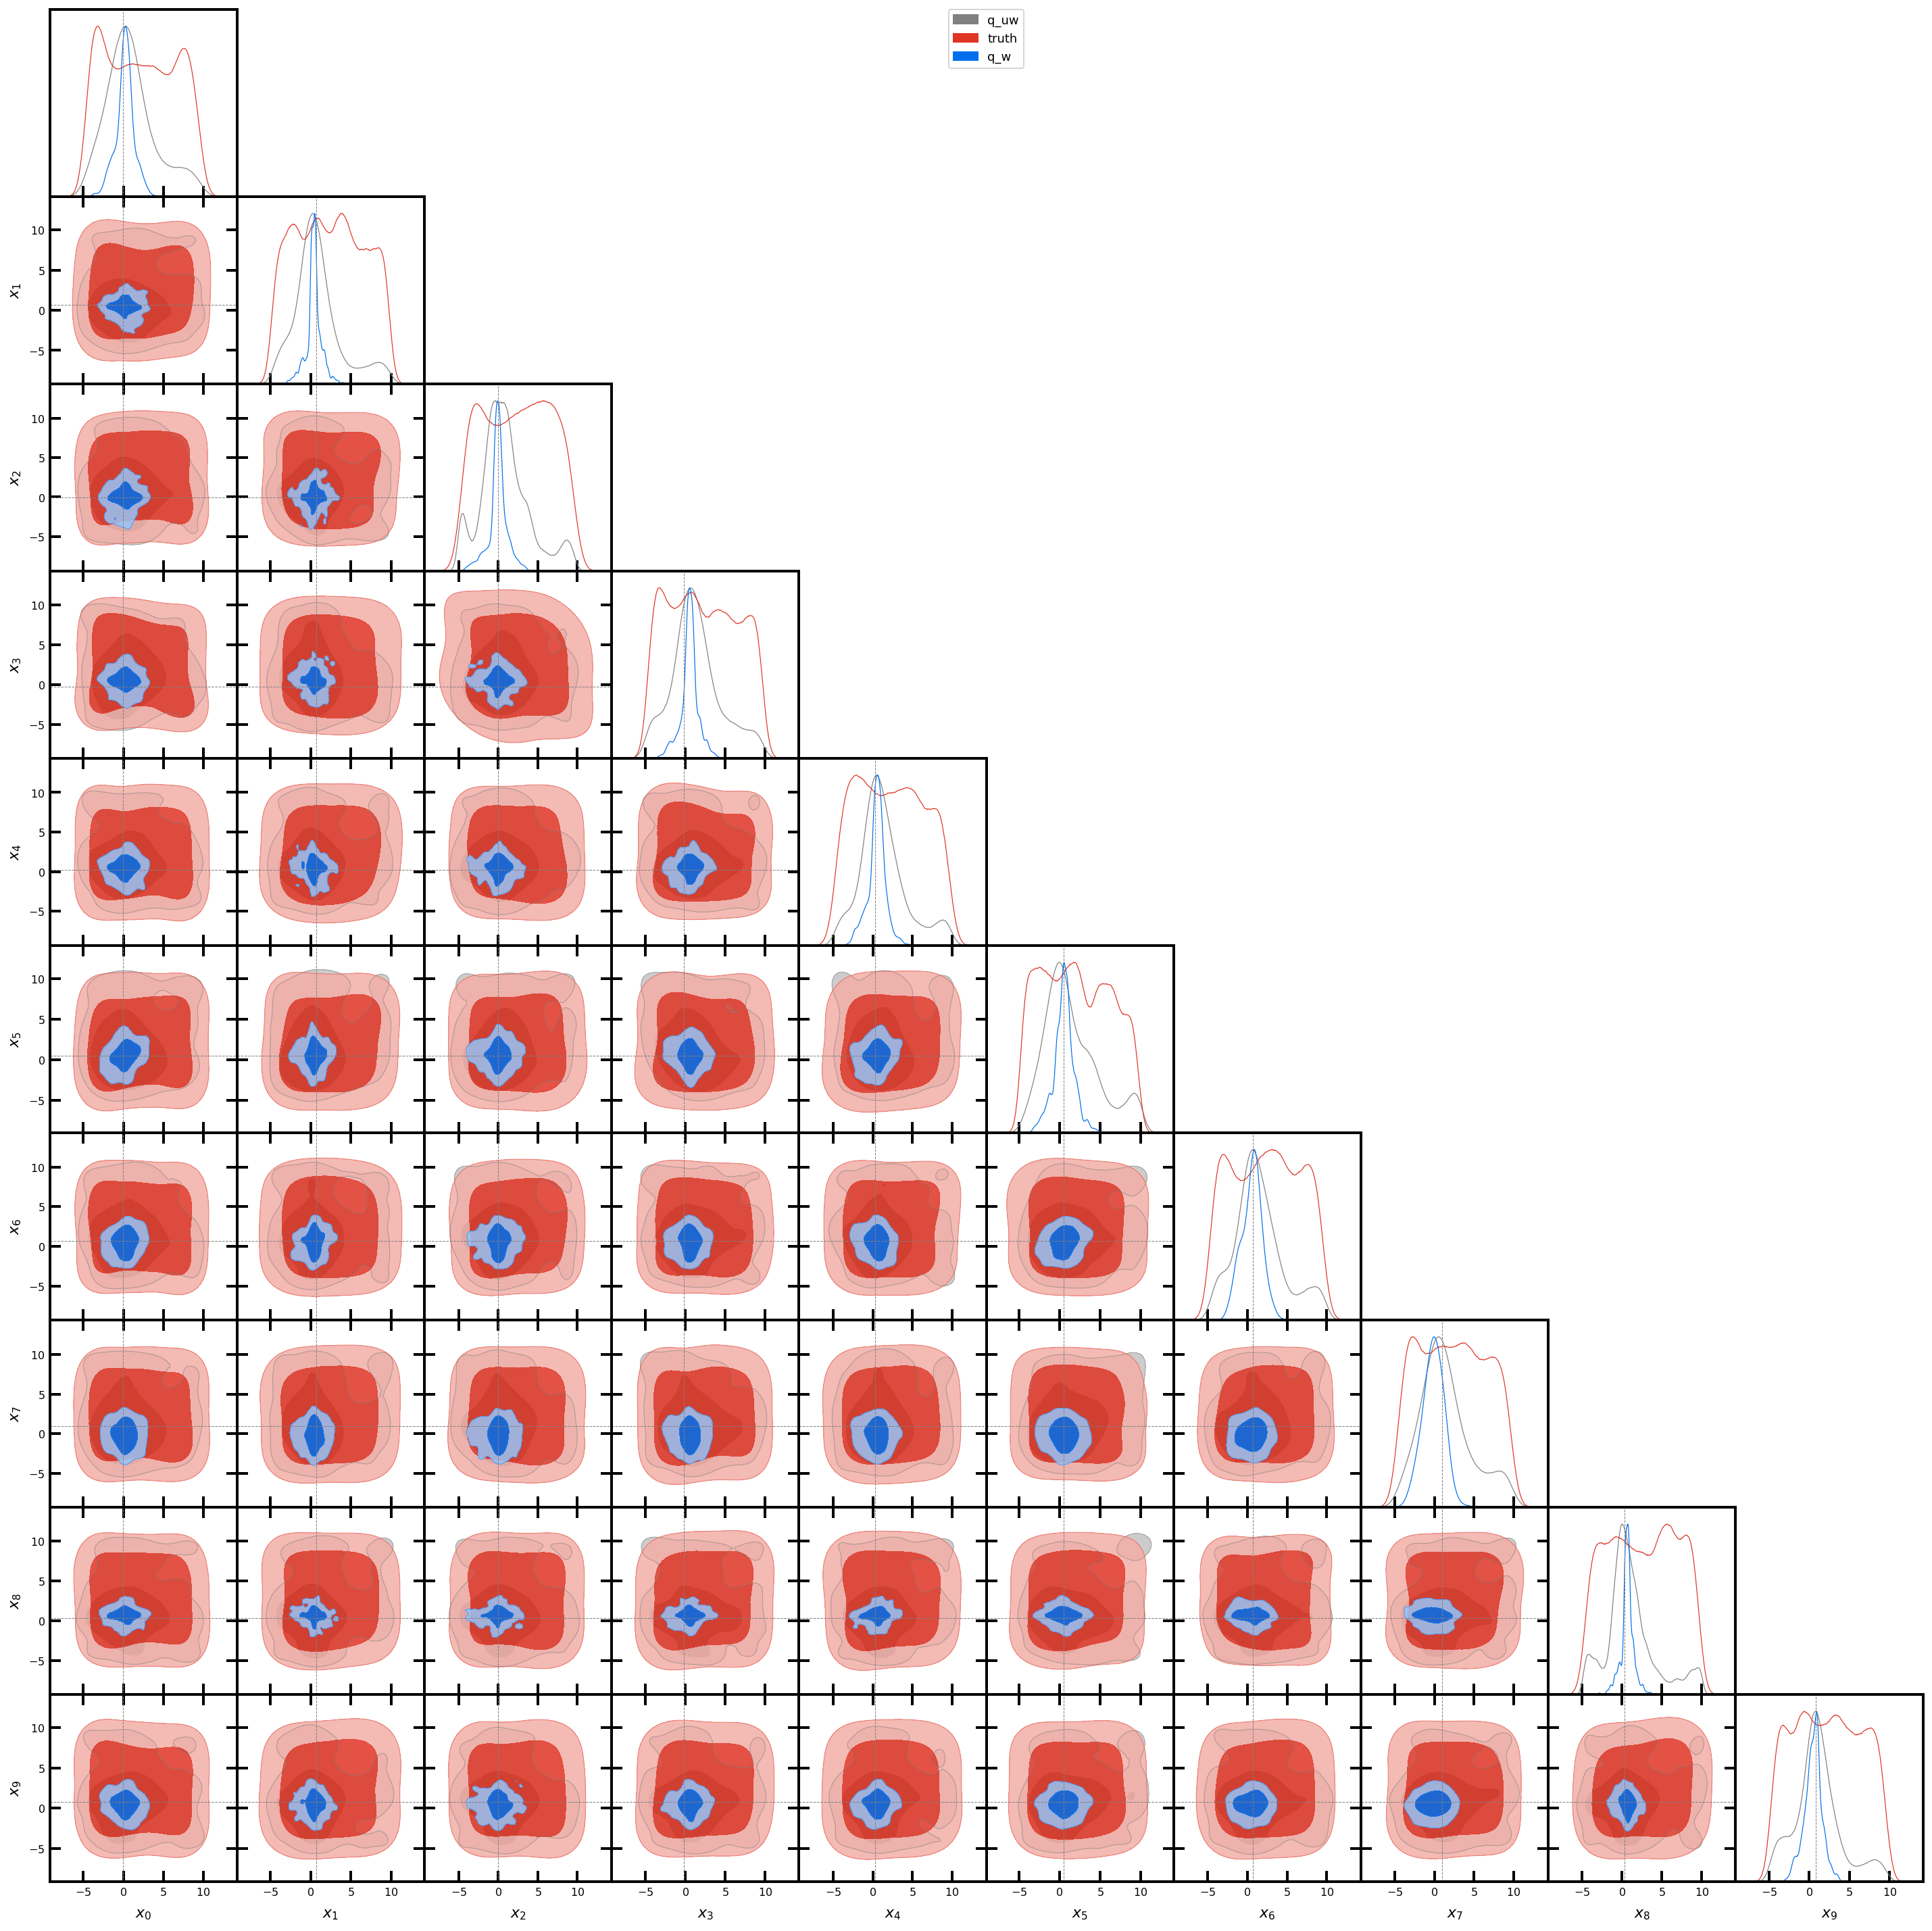

In [39]:
n=10
plot_opt_gd(bmy10[-1],log_ack,lb,ub,beta_idx=None,Ngd=1000)

Not collapsing enough? It doesn't seem like we are in local min?

ess

In [40]:
def impulse_schedule10(N,t1=0.7,t2=0.9,switch=200,N0=100):
    if(N<=switch):
        t = t1*N0/N
    else:
        t = t2*switch/N 
    return t

Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
Inference mode is optimization. Maximum beta is: 10
0.7
value of max logp = 2.75433611869812, at [ 0.9641762  -1.542897   -0.5737138   0.14679289  3.113182    2.0929365
  3.06256     0.91848755  1.232666    0.02099085], with 11 levels and 320 total calls
0.9
value of max logp = 2.735062599182129, at [ 1.8169022  -0.04765272 -2.070078    3.519329    0.37498713  1.5435162
  1.485867   -0.8741417  -0.77497435  0.26973963], with 14 levels and 380 total calls
impulse
value of max logp = 2.724123001098633, at [ 1.3288007  -1.1581295   0.21302271  3.5929995   2.4829383  -0.27301502
 -1.1082726  -1.3244057   0.7597556   1.2470207 ], with 23 levels and 560 total calls
0.95
value of max logp = 2.8034915924072266, at [-1.6624973  -0.02178764 -0.35048008  1.0359473   0.39652967  2.7840843
 -0.67290306 -0.0426445  -2.1940246   0.25151682], with 

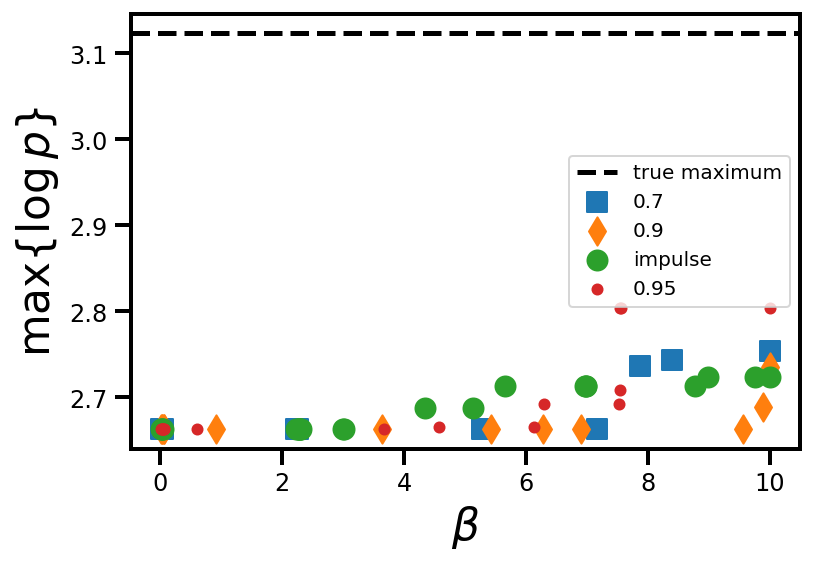

In [41]:
# Vary ess threshold 
ts10,ty10 = [0.7,0.9,impulse_schedule10,0.95],[]
tlabels10 = ['0.7','0.9','impulse','0.95']
for t in ts10: ty10.append(
                   run_nfo(n=10,log_like=log_ack10,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=10,d=1,c=0,b=2,rel_beta=1,t_ess=t,lossfunc=2,
                 ))
for i,tyi in enumerate(ty10):  #info about the run
    print(tlabels10[i])
    get_metrics(tyi)
plot_maxs(ty10,labels=tlabels10) #plots

Inference mode is optimization. Maximum beta is: 20
Inference mode is optimization. Maximum beta is: 20
Inference mode is optimization. Maximum beta is: 20
rel_beta = 0.5
value of max logp = 2.772275447845459, at [ 0.33866405  1.1087646   2.7134128   1.5210047   0.20440865 -0.1145277
  0.8380089  -2.977697    2.0016413   0.1290574 ], with 23 levels and 770 total calls
rel_beta = 0.75
value of max logp = 2.8504786491394043, at [-2.0798082  -1.1178586   0.41759253  0.07600069  1.9388137  -0.3778801
  0.68539095 -0.3119998  -0.73271275 -0.8158593 ], with 24 levels and 800 total calls
rel_beta = 1.0
value of max logp = 2.8971166610717773, at [ 0.70244265  1.410779   -0.20669222  1.6046057   0.77374744  0.8550525
 -0.36676311  0.01885653 -0.10156155 -0.07674456], with 22 levels and 540 total calls


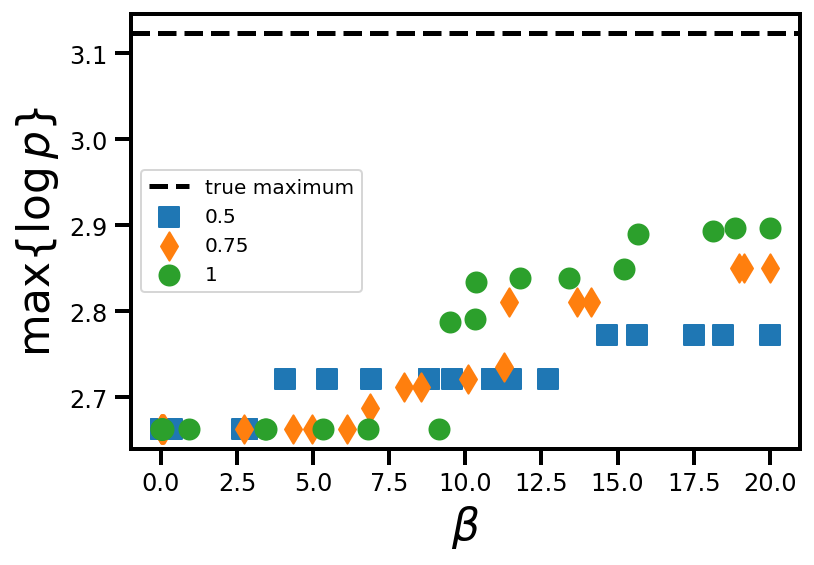

In [42]:
# rel_beta
rbs,rby = [0.5,0.75,1],[]
for rb in rbs: rby.append(
                   run_nfo(n=10,log_like=log_ack10,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=20,d=1,c=0,b=2,rel_beta=rb,t_ess=0.9,lossfunc=2,
                 ))
for i,rbyi in enumerate(rby): 
    print("rel_beta = {0}".format(float(rbs[i])))
    get_metrics(rbyi)
plot_maxs(rby,labels=rbs) 

More calls and worse results for lower rel_beta

Inference mode is optimization. Maximum beta is: 20
Inference mode is optimization. Maximum beta is: 20
Inference mode is optimization. Maximum beta is: 20
Inference mode is optimization. Maximum beta is: 20
n0 = 10.0
value of max logp = 2.8256771564483643, at [ 0.05185604  0.20959425  1.0218005  -1.1993625  -0.5003524   1.1603675
 -0.2770238  -0.1444335   0.43495178 -3.2213726 ], with 9 levels and 190 total calls
n0 = 50.0
value of max logp = 2.7850983142852783, at [-0.42529202 -0.0246706   1.806828   -1.6289225  -0.39892912  2.1365347
 -0.7173338   2.094277    1.5432725  -0.9254999 ], with 20 levels and 450 total calls
n0 = 100.0
value of max logp = 2.8971166610717773, at [ 0.70244265  1.410779   -0.20669222  1.6046057   0.77374744  0.8550525
 -0.36676311  0.01885653 -0.10156155 -0.07674456], with 22 levels and 540 total calls
n0 = 150.0
value of max logp = 2.910175085067749, at [ 0.1079874  -0.718585    0.77144814 -0.18998241  0.12504339 -0.18585825
  1.8139567   0.67347765 -0.41795

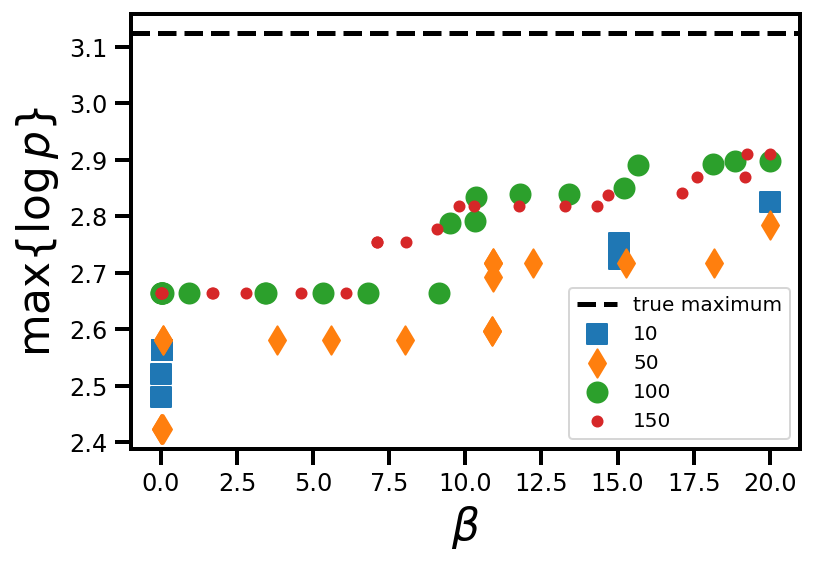

In [43]:
# initial samples
n0s,n0y = [10, 50,100,150],[]
for n0 in n0s: n0y.append(
                   run_nfo(n_prior=n0,n=10,log_like=log_ack10,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=20,d=1,c=0,b=2,rel_beta=1,t_ess=0.9,lossfunc=2,
                 ))
for i,n0yi in enumerate(n0y): 
    print("n0 = {0}".format(float(n0s[i])))
    get_metrics(n0yi)
plot_maxs(n0y,labels=n0s) 

### Oddly, using more initial points seems to help at first, but then do the same or worse at higher beta. Maybe suprisingly, even 10 does not seem to have a huge effect? Some savings here?

Inference mode is optimization. Maximum beta is: 50.0
Inference mode is optimization. Maximum beta is: 100.0
Inference mode is optimization. Maximum beta is: 200.0
beta_max = 50.0
value of max logp = 2.990004539489746, at [ 0.6064248   0.1194663  -0.07248831  0.2789569   0.02473307  0.8302603
 -0.08671284  0.9466381   0.24161291 -0.02622557], with 33 levels and 710 total calls
beta_max = 100.0
value of max logp = 3.0182385444641113, at [ 0.14054918  0.23901892  0.11543226 -0.03323126 -0.1307621   0.07186937
  0.8787689   0.7698245   0.09942913 -0.04329967], with 48 levels and 1010 total calls
beta_max = 200.0
value of max logp = 3.026257276535034, at [-0.0115242   0.01249456 -0.03939533  0.05099201  0.09812737 -0.20893383
  0.5138192   0.04756069 -0.7287555   0.08860064], with 60 levels and 1250 total calls


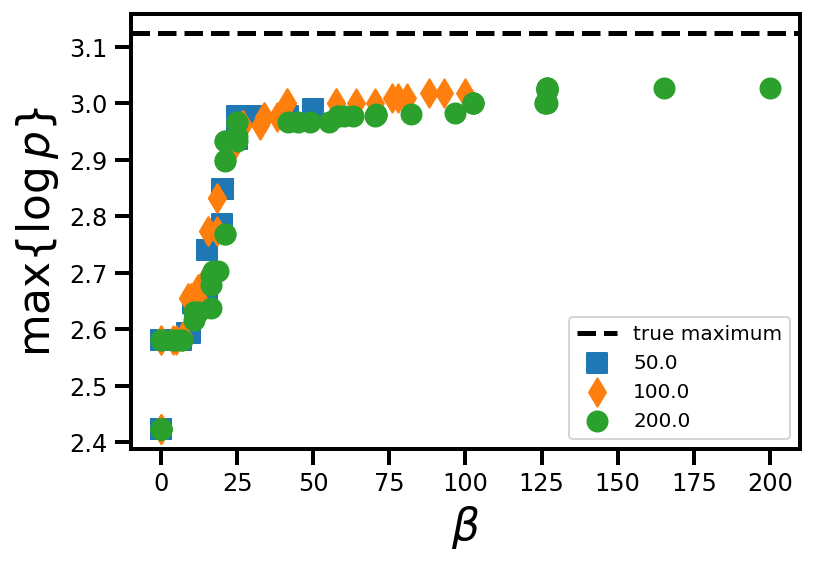

In [44]:
# More extreme beta_max
bms10,bmy10 = [50.,100.,200.],[]
for bm in bms10: bmy10.append(
                   run_nfo(n_prior=50,n=10,log_like=log_ack10,log_prior=log_flat_one,top_verbose=False,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=bm,d=1,c=0,b=2,rel_beta=1,t_ess=0.9,lossfunc=2,
                   
                 ))
for i,bmyi in enumerate(bmy10):  #info about the run
    print("beta_max = {0}".format(float(bms10[i])))
    get_metrics(bmyi)
plot_maxs(bmy10,labels=bms10) #plots

---
---
---

### Old

### $d=200$

In [ ]:
#with turbo settings now
def log_ack200(x): return log_ack(200,x)
n=200
ack200 =  run_nfo(n_prior=500,n=200,log_like=log_ack200,log_prior=log_flat_one,top_verbose=True,verbose=False,
                   low=lb,high=ub,random_init=True,beta_max=100,d=1,c=0,b=2,rel_beta=1,t_ess=0.9,lossfunc=2,
                   
                 )

In [ ]:
get_metrics(ack200)
plot_maxs(ack200,labels=bms10) #plots